In [1]:
# doing the same data preprocessing on the test set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# to see all columns of the dataset
pd.set_option('display.max_columns', None)

In [2]:
# because the one hot encoding on train and test might be different,
# we need to do it on the whole dataset
# and then split it again
# the initial data was train.csv and test.csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# store the target column one the train set seperately and drop it
y_train = train['SalePrice']
X_train = train.drop(columns=['SalePrice'])

# Combine the train and test sets
combined = pd.concat([X_train, test], keys=['train', 'test'])

In [3]:
train.shape, test.shape, X_train.shape, combined.shape

((1460, 81), (1459, 80), (1460, 80), (2919, 80))

In [4]:
# categorizing features
categorical_features = [feature for feature in combined.columns if combined[feature].dtypes == 'O']
numerical_features = [feature for feature in combined.columns if combined[feature].dtypes != 'O']
year_features = [feature for feature in numerical_features if 'Yr' in feature 
                 or 'Year' in feature]
discrete_features = [feature for feature in numerical_features if 
                     len(combined[feature].unique()) < 25 and feature not in year_features + ['Id']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features + year_features + ['Id']]
combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   

In [5]:
print('Number of categorical features: ', len(categorical_features))
print('Number of numerical features: ', len(numerical_features))
print('Number of year features: ', len(year_features))
print('Number of discrete features: ', len(discrete_features))
print('Number of continuous features: ', len(continuous_features))

Number of categorical features:  43
Number of numerical features:  37
Number of year features:  4
Number of discrete features:  14
Number of continuous features:  18


There are 80 columns, 1 is Id.
- Number of categorical features:  43
- Number of numerical features:  37
    - Temporal features (year related): 4
    - Discrete features: 14
    - Continuous features: 18
    - one more column is Id

In [6]:
missing = combined.isnull().sum()
missing = missing[missing > 0]
missing_percent = missing / combined.shape[0] * 100
missing_info = pd.DataFrame({'missing_values': missing, 'missing_percent': round(missing_percent,2)})
missing_info

,missing_values,missing_percent
MSZoning,4,0.14
LotFrontage,486,16.65
Alley,2721,93.22
Utilities,2,0.07
Exterior1st,1,0.03
Exterior2nd,1,0.03
MasVnrType,1766,60.50
MasVnrArea,23,0.79
BsmtQual,81,2.77
BsmtCond,82,2.81


In [7]:
# missing values in categorical features
categorical_nan = [feature for feature in categorical_features if combined[feature].isnull().sum() > 0]

for feature in categorical_nan:
    print('{} has {} % missing values'.format(feature, round(combined[feature].isnull().mean()*100, 2)))

MSZoning has 0.14 % missing values
Alley has 93.22 % missing values
Utilities has 0.07 % missing values
Exterior1st has 0.03 % missing values
Exterior2nd has 0.03 % missing values
MasVnrType has 60.5 % missing values
BsmtQual has 2.77 % missing values
BsmtCond has 2.81 % missing values
BsmtExposure has 2.81 % missing values
BsmtFinType1 has 2.71 % missing values
BsmtFinType2 has 2.74 % missing values
Electrical has 0.03 % missing values
KitchenQual has 0.03 % missing values
Functional has 0.07 % missing values
FireplaceQu has 48.65 % missing values
GarageType has 5.38 % missing values
GarageFinish has 5.45 % missing values
GarageQual has 5.45 % missing values
GarageCond has 5.45 % missing values
PoolQC has 99.66 % missing values
Fence has 80.44 % missing values
MiscFeature has 96.4 % missing values
SaleType has 0.03 % missing values


In [8]:
# replace nan value with a new label ('missing')
# this new label will be considered as a new category
data = combined.copy()
data[categorical_nan] = data[categorical_nan].fillna('missing')
data[categorical_nan].isnull().sum()


MSZoning        0
Alley           0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
KitchenQual     0
Functional      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
SaleType        0
dtype: int64

In [9]:
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street    Alley  \
train 0   1          60       RL         65.0     8450   Pave  missing   
      1   2          20       RL         80.0     9600   Pave  missing   
      2   3          60       RL         68.0    11250   Pave  missing   
      3   4          70       RL         60.0     9550   Pave  missing   
      4   5          60       RL         84.0    14260   Pave  missing   

        LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
train 0      Reg         Lvl    AllPub    Inside       Gtl      CollgCr   
      1      Reg         Lvl    AllPub       FR2       Gtl      Veenker   
      2      IR1         Lvl    AllPub    Inside       Gtl      CollgCr   
      3      IR1         Lvl    AllPub    Corner       Gtl      Crawfor   
      4      IR1         Lvl    AllPub       FR2       Gtl      NoRidge   

        Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
train 0       Norm       Norm     1Fam     2Story            7            5   
      1      Feedr       Norm     1Fam     1Story            6            8   
      2       Norm       Norm     1Fam     2Story            7            5   
      3       Norm       Norm     1Fam     2Story            7            5   
      4       Norm       Norm     1Fam     2Story            8            5   

         YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
train 0       2003          2003     Gable  CompShg     VinylSd     VinylSd   
      1       1976          1976     Gable  CompShg     MetalSd     MetalSd   
      2       2001          2002     Gable  CompShg     VinylSd     VinylSd   
      3       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng   
      4       2000          2000     Gable  CompShg     VinylSd     VinylSd   

        MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
train 0    BrkFace       196.0        Gd        TA      PConc       Gd   
      1    missing         0.0        TA        TA     CBlock       Gd   
      2    BrkFace       162.0        Gd        TA      PConc       Gd   
      3    missing         0.0        TA        TA     BrkTil       TA   
      4    BrkFace       350.0        Gd        TA      PConc       Gd   

        BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
train 0       TA           No          GLQ       706.0          Unf   
      1       TA           Gd          ALQ       978.0          Unf   
      2       TA           Mn          GLQ       486.0          Unf   
      3       Gd           No          ALQ       216.0          Unf   
      4       TA           Av          GLQ       655.0          Unf   

         BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir  \
train 0         0.0      150.0        856.0    GasA        Ex          Y   
      1         0.0      284.0       1262.0    GasA        Ex          Y   
      2         0.0      434.0        920.0    GasA        Ex          Y   
      3         0.0      540.0        756.0    GasA        Gd          Y   
      4         0.0      490.0       1145.0    GasA        Ex          Y   

        Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
train 0      SBrkr       856       854             0       1710           1.0   
      1      SBrkr      1262         0             0       1262           0.0   
      2      SBrkr       920       866             0       1786           1.0   
      3      SBrkr       961       756             0       1717           1.0   
      4      SBrkr      1145      1053             0       2198           1.0   

         BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train 0           0.0         2         1             3             1   
      1           1.0         2         0             3             1   
      2           0.0         2         1             3             1   
      3           0.0         1         0             3

In [10]:
# missing values in numerical features
numerical_nan = [feature for feature in numerical_features if data[feature].isnull().sum() > 0]
for feature in numerical_nan:
    print('{} has {} % missing values'.format(feature, round(data[feature].isnull().mean()*100, 2)))

LotFrontage has 16.65 % missing values
MasVnrArea has 0.79 % missing values
BsmtFinSF1 has 0.03 % missing values
BsmtFinSF2 has 0.03 % missing values
BsmtUnfSF has 0.03 % missing values
TotalBsmtSF has 0.03 % missing values
BsmtFullBath has 0.07 % missing values
BsmtHalfBath has 0.07 % missing values
GarageYrBlt has 5.45 % missing values
GarageCars has 0.03 % missing values
GarageArea has 0.03 % missing values


In [11]:
# here we will replace the missing values with the median value
for feature in numerical_nan:
    median_value = data[feature].median()
    # create a new feature to capture nan values
    data[feature + '_nan'] = np.where(data[feature].isnull(), 1, 0)
    # replace nan values with median
    data[feature].fillna(median_value, inplace=True)

data[numerical_nan].isnull().sum()

/var/folders/my/7sqdr0js0pd30sdwhr22q0rm0000gn/T/ipykernel_23649/2703371233.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[feature].fillna(median_value, inplace=True)
/var/folders/my/7sqdr0js0pd30sdwhr22q0rm0000gn/T/ipykernel_23649/2703371233.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

In [12]:
# Check if there is any missing value in data
data.isnull().sum().sum(), data.shape

(0, (2919, 91))

In [13]:
# we will convert the year features into the age vs year sold
for feature in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data[feature] = data['YrSold'] - data[feature]

data[year_features].head()

YearBuilt  YearRemodAdd  GarageYrBlt  YrSold
train 0          5             5          5.0    2008
      1         31            31         31.0    2007
      2          7             6          7.0    2008
      3         91            36          8.0    2006
      4          8             8          8.0    2008

In [14]:
# because we want to use lognormal transformation, we need to check if there is any 0 value 
# in the continuous features and just keep the features that don't have 0 value for log transformation

[feature for feature in continuous_features if 0 not in data[feature].unique()]

['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']

In [15]:
num_features = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']

for feature in num_features:
    data[feature] = np.log(data[feature])

In [16]:
data.head()

Id  MSSubClass MSZoning  LotFrontage   LotArea Street    Alley  \
train 0   1          60       RL     4.174387  9.041922   Pave  missing   
      1   2          20       RL     4.382027  9.169518   Pave  missing   
      2   3          60       RL     4.219508  9.328123   Pave  missing   
      3   4          70       RL     4.094345  9.164296   Pave  missing   
      4   5          60       RL     4.430817  9.565214   Pave  missing   

        LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
train 0      Reg         Lvl    AllPub    Inside       Gtl      CollgCr   
      1      Reg         Lvl    AllPub       FR2       Gtl      Veenker   
      2      IR1         Lvl    AllPub    Inside       Gtl      CollgCr   
      3      IR1         Lvl    AllPub    Corner       Gtl      Crawfor   
      4      IR1         Lvl    AllPub       FR2       Gtl      NoRidge   

        Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
train 0       Norm       Norm     1Fam     2Story            7            5   
      1      Feedr       Norm     1Fam     1Story            6            8   
      2       Norm       Norm     1Fam     2Story            7            5   
      3       Norm       Norm     1Fam     2Story            7            5   
      4       Norm       Norm     1Fam     2Story            8            5   

         YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
train 0          5             5     Gable  CompShg     VinylSd     VinylSd   
      1         31            31     Gable  CompShg     MetalSd     MetalSd   
      2          7             6     Gable  CompShg     VinylSd     VinylSd   
      3         91            36     Gable  CompShg     Wd Sdng     Wd Shng   
      4          8             8     Gable  CompShg     VinylSd     VinylSd   

        MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
train 0    BrkFace       196.0        Gd        TA      PConc       Gd   
      1    missing         0.0        TA        TA     CBlock       Gd   
      2    BrkFace       162.0        Gd        TA      PConc       Gd   
      3    missing         0.0        TA        TA     BrkTil       TA   
      4    BrkFace       350.0        Gd        TA      PConc       Gd   

        BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
train 0       TA           No          GLQ       706.0          Unf   
      1       TA           Gd          ALQ       978.0          Unf   
      2       TA           Mn          GLQ       486.0          Unf   
      3       Gd           No          ALQ       216.0          Unf   
      4       TA           Av          GLQ       655.0          Unf   

         BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir  \
train 0         0.0      150.0        856.0    GasA        Ex          Y   
      1         0.0      284.0       1262.0    GasA        Ex          Y   
      2         0.0      434.0        920.0    GasA        Ex          Y   
      3         0.0      540.0        756.0    GasA        Gd          Y   
      4         0.0      490.0       1145.0    GasA        Ex          Y   

        Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
train 0      SBrkr  6.752270       854             0   7.444249           1.0   
      1      SBrkr  7.140453         0             0   7.140453           0.0   
      2      SBrkr  6.824374       866             0   7.487734           1.0   
      3      SBrkr  6.867974       756             0   7.448334           1.0   
      4      SBrkr  7.043160      1053             0   7.695303           1.0   

         BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train 0           0.0         2         1             3             1   
      1           1.0         2         0             3             1   
      2           0.0         2         1             3             1   
      3           0.0         1         0        

In [17]:
# discovering the percentage of each category in each categorical feature
for feature in categorical_features:
    temp = data.groupby(feature)['Id'].count() / len(data)
    temp_df = temp[temp > 0.01].index
    data[feature] = np.where(data[feature].isin(temp_df), data[feature], 'Rare_var')

In [18]:
data.head()

Id  MSSubClass MSZoning  LotFrontage   LotArea Street    Alley  \
train 0   1          60       RL     4.174387  9.041922   Pave  missing   
      1   2          20       RL     4.382027  9.169518   Pave  missing   
      2   3          60       RL     4.219508  9.328123   Pave  missing   
      3   4          70       RL     4.094345  9.164296   Pave  missing   
      4   5          60       RL     4.430817  9.565214   Pave  missing   

        LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
train 0      Reg         Lvl    AllPub    Inside       Gtl      CollgCr   
      1      Reg         Lvl    AllPub       FR2       Gtl     Rare_var   
      2      IR1         Lvl    AllPub    Inside       Gtl      CollgCr   
      3      IR1         Lvl    AllPub    Corner       Gtl      Crawfor   
      4      IR1         Lvl    AllPub       FR2       Gtl      NoRidge   

        Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
train 0       Norm       Norm     1Fam     2Story            7            5   
      1      Feedr       Norm     1Fam     1Story            6            8   
      2       Norm       Norm     1Fam     2Story            7            5   
      3       Norm       Norm     1Fam     2Story            7            5   
      4       Norm       Norm     1Fam     2Story            8            5   

         YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
train 0          5             5     Gable  CompShg     VinylSd     VinylSd   
      1         31            31     Gable  CompShg     MetalSd     MetalSd   
      2          7             6     Gable  CompShg     VinylSd     VinylSd   
      3         91            36     Gable  CompShg     Wd Sdng     Wd Shng   
      4          8             8     Gable  CompShg     VinylSd     VinylSd   

        MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
train 0    BrkFace       196.0        Gd        TA      PConc       Gd   
      1    missing         0.0        TA        TA     CBlock       Gd   
      2    BrkFace       162.0        Gd        TA      PConc       Gd   
      3    missing         0.0        TA        TA     BrkTil       TA   
      4    BrkFace       350.0        Gd        TA      PConc       Gd   

        BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
train 0       TA           No          GLQ       706.0          Unf   
      1       TA           Gd          ALQ       978.0          Unf   
      2       TA           Mn          GLQ       486.0          Unf   
      3       Gd           No          ALQ       216.0          Unf   
      4       TA           Av          GLQ       655.0          Unf   

         BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir  \
train 0         0.0      150.0        856.0    GasA        Ex          Y   
      1         0.0      284.0       1262.0    GasA        Ex          Y   
      2         0.0      434.0        920.0    GasA        Ex          Y   
      3         0.0      540.0        756.0    GasA        Gd          Y   
      4         0.0      490.0       1145.0    GasA        Ex          Y   

        Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
train 0      SBrkr  6.752270       854             0   7.444249           1.0   
      1      SBrkr  7.140453         0             0   7.140453           0.0   
      2      SBrkr  6.824374       866             0   7.487734           1.0   
      3      SBrkr  6.867974       756             0   7.448334           1.0   
      4      SBrkr  7.043160      1053             0   7.695303           1.0   

         BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train 0           0.0         2         1             3             1   
      1           1.0         2         0             3             1   
      2           0.0         2         1             3             1   
      3           0.0         1         0        

In [19]:
# one hot encoding for categorical features
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']
data_encoded = pd.get_dummies(data,columns=categorical_features, drop_first=True)
data_encoded = data_encoded.astype(float)
data_encoded.head()

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
train 0  1.0        60.0     4.174387  9.041922          7.0          5.0   
      1  2.0        20.0     4.382027  9.169518          6.0          8.0   
      2  3.0        60.0     4.219508  9.328123          7.0          5.0   
      3  4.0        70.0     4.094345  9.164296          7.0          5.0   
      4  5.0        60.0     4.430817  9.565214          8.0          5.0   

         YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
train 0        5.0           5.0       196.0       706.0         0.0   
      1       31.0          31.0         0.0       978.0         0.0   
      2        7.0           6.0       162.0       486.0         0.0   
      3       91.0          36.0         0.0       216.0         0.0   
      4        8.0           8.0       350.0       655.0         0.0   

         BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
train 0      150.0        856.0  6.752270     854.0           0.0   7.444249   
      1      284.0       1262.0  7.140453       0.0           0.0   7.140453   
      2      434.0        920.0  6.824374     866.0           0.0   7.487734   
      3      540.0        756.0  6.867974     756.0           0.0   7.448334   
      4      490.0       1145.0  7.043160    1053.0           0.0   7.695303   

         BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
train 0           1.0           0.0       2.0       1.0           3.0   
      1           0.0           1.0       2.0       0.0           3.0   
      2           1.0           0.0       2.0       1.0           3.0   
      3           1.0           0.0       1.0       0.0           3.0   
      4           1.0           0.0       2.0       1.0           4.0   

         KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
train 0           1.0           8.0         0.0          5.0         2.0   
      1           1.0           6.0         1.0         31.0         2.0   
      2           1.0           6.0         1.0          7.0         2.0   
      3           1.0           7.0         1.0          8.0         3.0   
      4           1.0           9.0         1.0          8.0         3.0   

         GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
train 0       548.0         0.0         61.0            0.0        0.0   
      1       460.0       298.0          0.0            0.0        0.0   
      2       608.0         0.0         42.0            0.0        0.0   
      3       642.0         0.0         35.0          272.0        0.0   
      4       836.0       192.0         84.0            0.0        0.0   

         ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  LotFrontage_nan  \
train 0          0.0       0.0      0.0     2.0  2008.0              0.0   
      1          0.0       0.0      0.0     5.0  2007.0              0.0   
      2          0.0       0.0      0.0     9.0  2008.0              0.0   
      3          0.0       0.0      0.0     2.0  2006.0              0.0   
      4          0.0       0.0      0.0    12.0  2008.0              0.0   

         MasVnrArea_nan  BsmtFinSF1_nan  BsmtFinSF2_nan  BsmtUnfSF_nan  \
train 0             0.0             0.0             0.0            0.0   
      1             0.0             0.0             0.0            0.0   
      2             0.0             0.0             0.0            0.0   
      3             0.0             0.0             0.0            0.0   
      4             0.0             0.0             0.0            0.0   

         TotalBsmtSF_nan  BsmtFullBath_nan  BsmtHalfBath_nan  GarageYrBlt_nan  \
train 0              0.0               0.0               0.0              0.0   
      1              0.0               0.0               0.0              0.0   
      2              0.0               0.0               0.0              0.0   
      3              0.0               0.0               0.0      

In [20]:
# feature scaling
feature_scale = [feature for feature in numerical_features if feature not in ['Id']]

from sklearn.preprocessing import MinMaxScaler
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
data_encoded[feature_scale] = scaler.fit_transform(data_encoded[feature_scale])

In [21]:
data_encoded.head()

Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
train 0  1.0    0.235294     0.418208  0.366344     0.666667        0.500   
      1  2.0    0.000000     0.495064  0.391317     0.555556        0.875   
      2  3.0    0.235294     0.434909  0.422359     0.666667        0.500   
      3  4.0    0.294118     0.388581  0.390295     0.666667        0.500   
      4  5.0    0.235294     0.513123  0.468761     0.777778        0.500   

         YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
train 0   0.043796      0.112903     0.12250    0.125089         0.0   
      1   0.233577      0.532258     0.00000    0.173281         0.0   
      2   0.058394      0.129032     0.10125    0.086109         0.0   
      3   0.671533      0.612903     0.00000    0.038271         0.0   
      4   0.065693      0.161290     0.21875    0.116052         0.0   

         BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
train 0   0.064212     0.140098  0.345385  0.413559           0.0   0.577712   
      1   0.121575     0.206547  0.487844  0.000000           0.0   0.470245   
      2   0.185788     0.150573  0.371846  0.419370           0.0   0.593095   
      3   0.231164     0.123732  0.387847  0.366102           0.0   0.579157   
      4   0.209760     0.187398  0.452138  0.509927           0.0   0.666523   

         BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
train 0      0.333333           0.0      0.50       0.5         0.375   
      1      0.000000           0.5      0.50       0.0         0.375   
      2      0.333333           0.0      0.50       0.5         0.375   
      3      0.333333           0.0      0.25       0.0         0.375   
      4      0.333333           0.0      0.50       0.5         0.500   

         KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
train 0      0.333333      0.461538        0.00     0.652866         0.4   
      1      0.333333      0.307692        0.25     0.735669         0.4   
      2      0.333333      0.307692        0.25     0.659236         0.4   
      3      0.333333      0.384615        0.25     0.662420         0.6   
      4      0.333333      0.538462        0.25     0.662420         0.6   

         GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
train 0    0.368280    0.000000     0.082210       0.000000        0.0   
      1    0.309140    0.209270     0.000000       0.000000        0.0   
      2    0.408602    0.000000     0.056604       0.000000        0.0   
      3    0.431452    0.000000     0.047170       0.268775        0.0   
      4    0.561828    0.134831     0.113208       0.000000        0.0   

         ScreenPorch  PoolArea  MiscVal    MoSold  YrSold  LotFrontage_nan  \
train 0          0.0       0.0      0.0  0.090909    0.50              0.0   
      1          0.0       0.0      0.0  0.363636    0.25              0.0   
      2          0.0       0.0      0.0  0.727273    0.50              0.0   
      3          0.0       0.0      0.0  0.090909    0.00              0.0   
      4          0.0       0.0      0.0  1.000000    0.50              0.0   

         MasVnrArea_nan  BsmtFinSF1_nan  BsmtFinSF2_nan  BsmtUnfSF_nan  \
train 0             0.0             0.0             0.0            0.0   
      1             0.0             0.0             0.0            0.0   
      2             0.0             0.0             0.0            0.0   
      3             0.0             0.0             0.0            0.0   
      4             0.0             0.0             0.0            0.0   

         TotalBsmtSF_nan  BsmtFullBath_nan  BsmtHalfBath_nan  GarageYrBlt_nan  \
train 0              0.0               0.0               0.0              0.0   
      1              0.0               0.0               0.0              0.0   
      2              0.0               0.0               0.0              0.0   
      3              0.0               0.0            

In [22]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Columns: 215 entries, Id to SaleCondition_Rare_var
dtypes: float64(215)
memory usage: 4.8+ MB


In [23]:
# split the data back to train and test
X_train = data_encoded.loc['train']
X_test = data_encoded.loc['test']

In [24]:
X_train.shape, X_test.shape

((1460, 215), (1459, 215))

In [25]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_nan,MasVnrArea_nan,BsmtFinSF1_nan,BsmtFinSF2_nan,BsmtUnfSF_nan,TotalBsmtSF_nan,BsmtFullBath_nan,BsmtHalfBath_nan,GarageYrBlt_nan,GarageCars_nan,GarageArea_nan,MSZoning_RL,MSZoning_RM,MSZoning_Rare_var,Street_Rare_var,Alley_Pave,Alley_missing,LotShape_IR2,LotShape_Rare_var,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_Rare_var,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,LotConfig_Rare_var,LandSlope_Mod,LandSlope_Rare_var,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Rare_var,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAn,Condition1_Rare_var,Condition2_Rare_var,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare_var,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Rare_var,RoofMatl_Rare_var,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Rare_var,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Rare_var,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_Rare_var,MasVnrType_Stone,MasVnrType_missing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Gd,ExterCond_Rare_var,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Rare_var,Foundation_Slab,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_missing,BsmtCond_Gd,BsmtCond_Rare_var,BsmtCond_TA,BsmtCond_missing,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_missing,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_missing,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_missing,Heating_Rare_var,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Rare_var,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_Rare_var,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Rare_var,KitchenQual_TA,Functional_Min2,Functional_Mod,Functional_Rare_var,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_missing,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_Rare_var,GarageType_missing,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing,GarageQual_Rare_var,GarageQual_TA,GarageQual_missing,GarageCond_Rare_var,GarageCond_TA,GarageCond_missing,PavedDrive_P,PavedDrive_Y,PoolQC_missing,Fence_GdWo,Fence_MnPrv,Fence_Rare_var,Fence_missing,MiscFeature_Shed,MiscFeature_missing,SaleType_New,SaleType_Rare_var,SaleType_WD,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare_var
0,1.0,0.235294,0.418208,0.366344,0.666667,0.500,0.043796,0.112903,0.12250,0.125089,0.0,0.064212,0.140098,0.345385,0.413559,0.0,0.577712,0.333333,0.0,0.50,0.5,0.375,0.333333,0.461538,0.00,0.652866,0.4,0.368280,0.000000,0.082210,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [26]:
X_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_nan,MasVnrArea_nan,BsmtFinSF1_nan,BsmtFinSF2_nan,BsmtUnfSF_nan,TotalBsmtSF_nan,BsmtFullBath_nan,BsmtHalfBath_nan,GarageYrBlt_nan,GarageCars_nan,GarageArea_nan,MSZoning_RL,MSZoning_RM,MSZoning_Rare_var,Street_Rare_var,Alley_Pave,Alley_missing,LotShape_IR2,LotShape_Rare_var,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_Rare_var,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,LotConfig_Rare_var,LandSlope_Mod,LandSlope_Rare_var,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Rare_var,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAn,Condition1_Rare_var,Condition2_Rare_var,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare_var,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Rare_var,RoofMatl_Rare_var,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Rare_var,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Rare_var,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_Rare_var,MasVnrType_Stone,MasVnrType_missing,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Gd,ExterCond_Rare_var,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Rare_var,Foundation_Slab,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_missing,BsmtCond_Gd,BsmtCond_Rare_var,BsmtCond_TA,BsmtCond_missing,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_missing,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_missing,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_missing,Heating_Rare_var,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Rare_var,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_Rare_var,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Rare_var,KitchenQual_TA,Functional_Min2,Functional_Mod,Functional_Rare_var,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_missing,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_Rare_var,GarageType_missing,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing,GarageQual_Rare_var,GarageQual_TA,GarageQual_missing,GarageCond_Rare_var,GarageCond_TA,GarageCond_missing,PavedDrive_P,PavedDrive_Y,PoolQC_missing,Fence_GdWo,Fence_MnPrv,Fence_Rare_var,Fence_missing,MiscFeature_Shed,MiscFeature_missing,SaleType_New,SaleType_Rare_var,SaleType_WD,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare_var
0,1461.0,0.000000,0.495064,0.428726,0.444444,0.625,0.364964,0.822581,0.0000,0.082920,0.094364,0.115582,0.144354,0.362145,0.000000,0.0,0.349081,0.0,0.0,0.25,0.0,0.250,0.333333,0.230769,0.00,0.792994,0.2,0.490591,0.098315,0.000000,0.0,0.0,0.208333,0.0,0.000000,0.454545,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [27]:
# training the model on whole training dataset
X = X_train.drop(columns= ['Id'])
y = y_train

# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model = GradientBoostingRegressor(n_estimators=400, random_state=41, learning_rate=0.05, 
#min_samples_leaf=3
)

# Fit the model
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=400, random_state=41)

In [28]:
# Store the Ids of test set separately before dropping the Id column
ids = X_test['Id']

# Drop the Id column from the test set
X_test = X_test.drop(columns=['Id'])

# Make predictions using the trained model
SalePrice = model.predict(X_test)

# Combine the Ids with the predictions
predictions = pd.DataFrame({'Id': ids, 'SalePrice': SalePrice})

# Display the predictions
predictions.head()

,Id,SalePrice
0,1461.0,117118.309828
1,1462.0,160712.413905
2,1463.0,179328.566739
3,1464.0,185515.746467
4,1465.0,187696.862164


In [29]:
# Kaggle needs the Id column to be integer
predictions['Id'] = predictions['Id'].astype(int)

In [30]:
# saving the predictions to csv file
predictions.to_csv('submission.csv', index=False)

The MSE on the unseen data of Kaggle is 0.13064 which is pretty good.

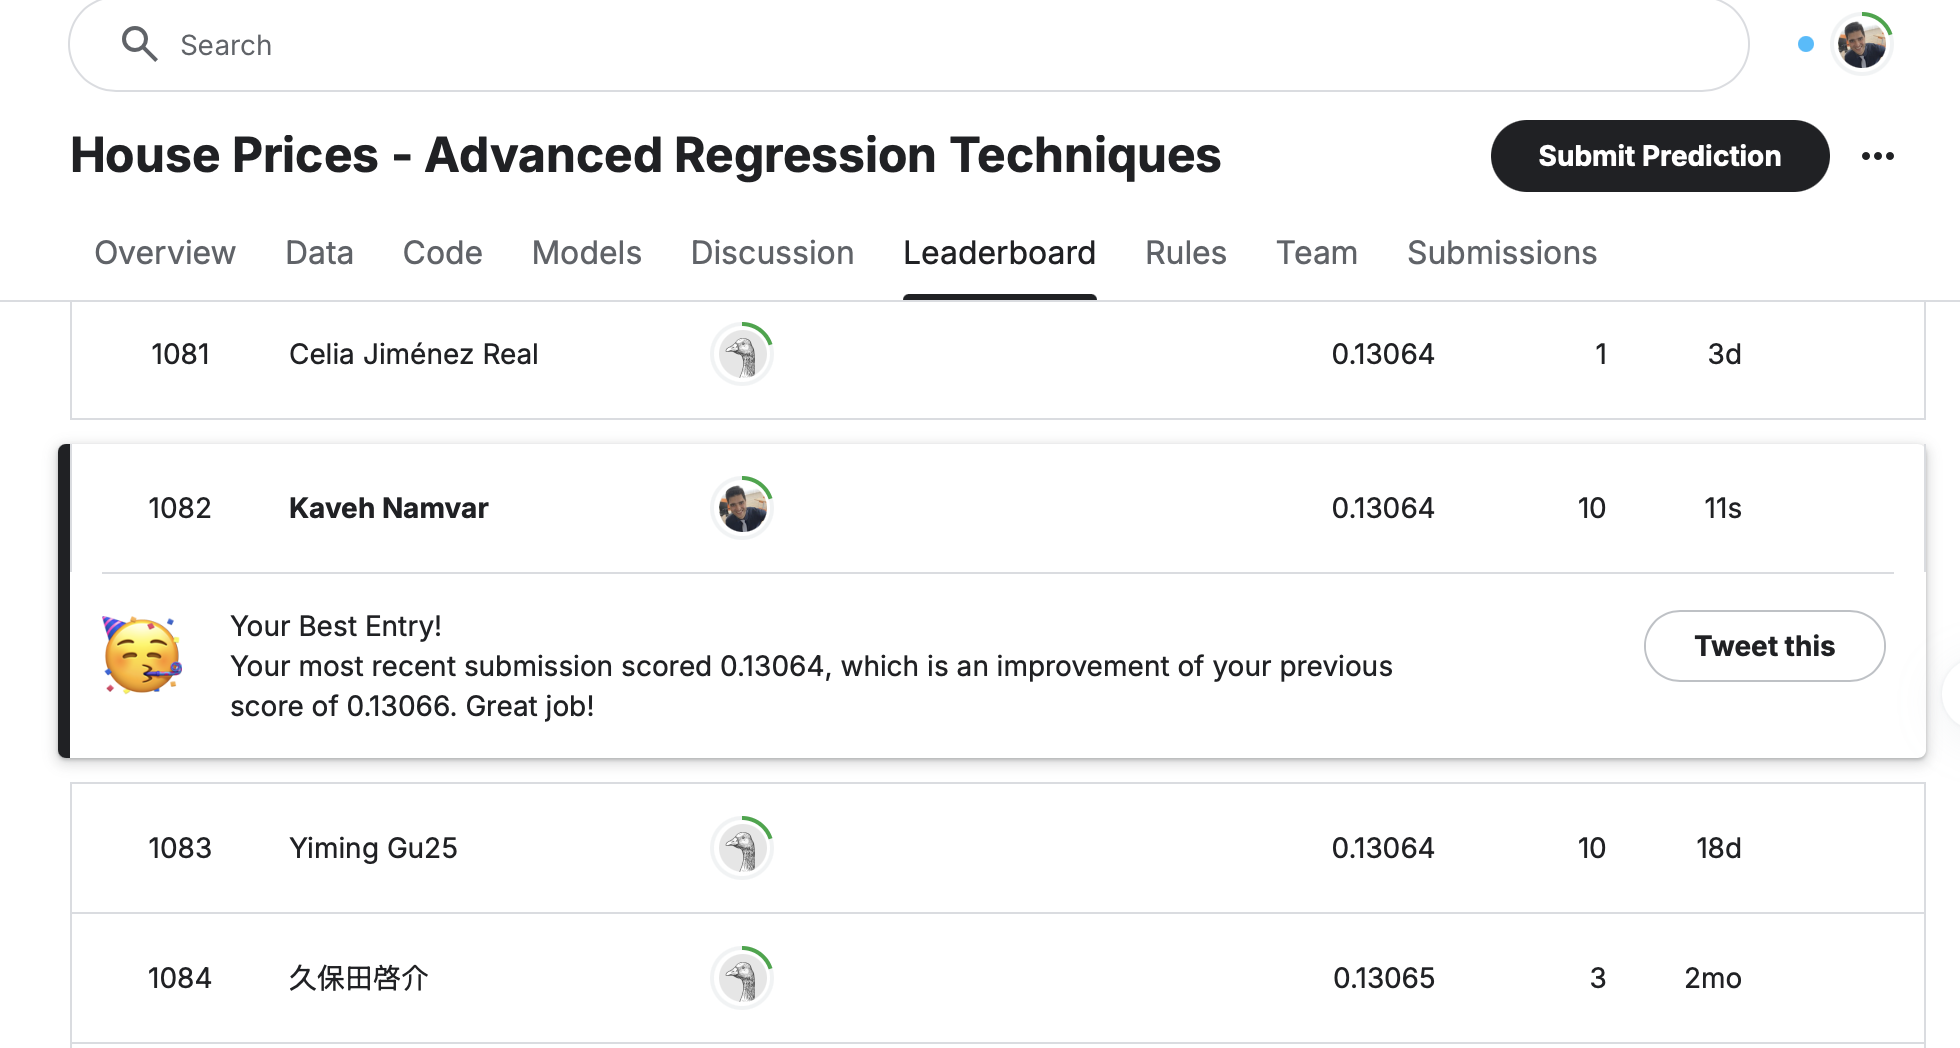